In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, sws_replace, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets, get_layer_data
from retrain_layer import retrain_layer
retraining_epochs = 50


test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()
#val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
#val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()


/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2000.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 10.0
Layer Loss: 153907.891
Layer Loss: 168.665
Layer Loss: 19609.299
Layer Loss: 66.420
Layer Loss: 668.307
Layer Loss: 6.222
0-neglogprop Loss: -11055.582
Remaining-neglogprop Loss: -39147.242
Tau: 5e-06, Epoch: 25. Test Accuracy: 98.50 Prune Accuracy: 98.27 Sparsity: 44.13


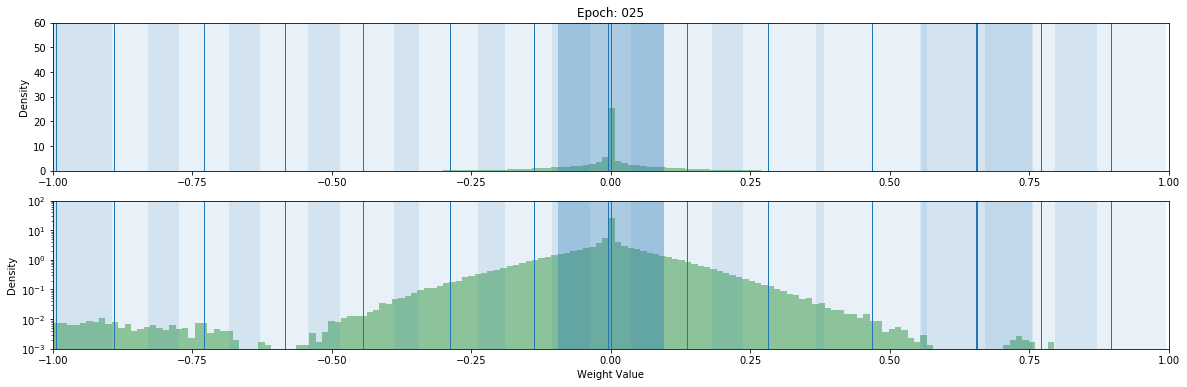

Tau: 5e-06, Epoch: 50. Test Accuracy: 98.49 Prune Accuracy: 98.41 Sparsity: 44.16


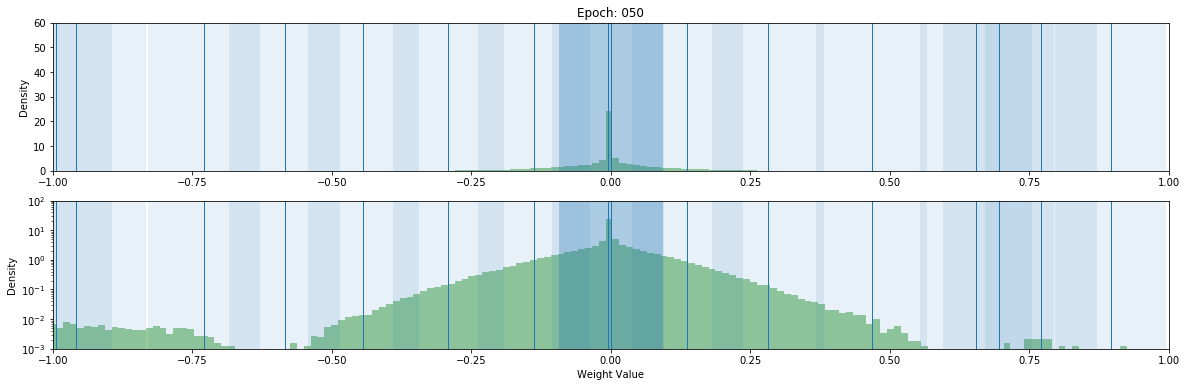

Tau: 5e-06, Epoch: 25. Test Accuracy: 98.50 Prune Accuracy: 98.27 Sparsity: 44.13
Tau: 5e-06, Epoch: 50. Test Accuracy: 98.49 Prune Accuracy: 98.41 Sparsity: 44.16



In [12]:
scaling = True
res_str = ""
for tau in [0.5e-5]:#, 2e-5, 4e-5, 6e-5, 8e-5, 10e-5]:
    model_name = "LeNet_300_100"
    data_size = "full"
    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model = torch.load(model_load_dir + model_file + '.m').cuda()

    targets_dict = get_targets(model_file)
    inputs = train_data(fetch = "data").cuda()
    targets = torch.cat((targets_dict['fc1.out'],targets_dict['fc2.out'],targets_dict['fc3.out']), 1).data.cuda()
    if data_size == "search":
        inputs = inputs[0:10000]
        targets = targets[0:10000]

    dataset = torch.utils.data.TensorDataset(inputs, targets)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    #Get targets at each layer
    gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99, zero_ab = get_ab(2000, 1000), ab = get_ab(100,10), scaling = scaling)
    opt_1 = torch.optim.Adam([{'params': model.fc1.parameters(), 'lr': 1e-4}])
    opt_2 = torch.optim.Adam([{'params': model.fc2.parameters(), 'lr': 1e-4}])
    opt_3 = torch.optim.Adam([{'params': model.fc3.parameters(), 'lr': 1e-4}])
    if (not scaling):
        opt_gmp = torch.optim.Adam([{'params': [gmp.means], 'lr': 3e-4}, {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])
    else:
        opt_gmp = torch.optim.Adam([{'params': [gmp.means], 'lr': 3e-5}, {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}, {'params': [gmp.scale], 'lr': 1e-6}])


    for epoch in range(retraining_epochs):
        for i, (images, targets) in enumerate(loader):
            images=images.cuda()
            targets=targets.cuda()
            images = Variable(images)
            targets = Variable(targets)	
            opt_1.zero_grad()
            opt_2.zero_grad()
            opt_3.zero_grad()
            opt_gmp.zero_grad()

            forward = model.layer_forward(images)
            loss_acc = nn.MSELoss()(forward, targets)

            loss = loss_acc + tau * gmp.call()
            loss.backward()

            opt_1.step()
            opt_2.step()
            opt_3.step()
            opt_gmp.step()
        if (trueAfterN(epoch, 25)):
            test_acc = test_accuracy(test_data_full, test_labels_full, model)
            prune_model = sws_prune_copy(model, gmp)
            prune_acc = test_accuracy(test_data_full, test_labels_full, prune_model)
            sparsity = get_sparsity(prune_model)
            res_str += 'Tau: {}, Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}\n'.format(tau, epoch+1, test_acc[0], prune_acc[0], sparsity)
            print('Tau: {}, Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}'.format(tau, epoch+1, test_acc[0], prune_acc[0], sparsity))
            show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
print (res_str)

In [ ]:
Tau: 1e-05, Epoch: 25. Test Accuracy: 98.17 Prune Accuracy: 97.33 Sparsity: 68.26
Tau: 1e-05, Epoch: 50. Test Accuracy: 98.05 Prune Accuracy: 97.49 Sparsity: 77.22

In [4]:
def sws_prune_l2(model_dict, gmp):
    if (gmp.scaling):
        scale = [1] + list(gmp.scale.exp().data.clone().cpu().numpy())
        layer_mult = [float(scale[int(i/2)]) for i in range(len(model_dict))]
        print (scale, layer_mult)
        weights = np.concatenate([model_dict[array].clone().cpu().numpy().flatten() / layer_mult[i] for i, array in enumerate(model_dict)])
        mult_list = layer_mult
    else:
        weights = np.concatenate([model_dict[array].clone().cpu().numpy().flatten() for i, array in enumerate(model_dict)])
    weights = weights.reshape((len(weights), 1))
    means = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])

    sorted_means = np.sort(means)
    bins = (sorted_means[1:] + sorted_means[:-1])/2

    for i, b in enumerate(bins):
        if (i==0):
            weights[np.where(weights < b)] = sorted_means[i]
        elif (i== len(bins)-1):
            weights[np.where(weights > b)] = sorted_means[i]
            weights[np.where(np.logical_and(weights < b, weights > prev_b))] = sorted_means[i]
        else:
            weights[np.where(np.logical_and(weights < b, weights > prev_b))] = sorted_means[i]
        prev_b = b
    #weights[np.where(np.abs(weights) < 0.1)] = 0
    out = weights
    pruned_state_dict = copy.deepcopy(model_dict)
    dim_start = 0


    for i, layer in enumerate(model_dict):
        layer_mult = 1
        if (gmp.scaling):
            layer_mult = mult_list[int(i)] #mult_list[int(i)]
        print (layer_mult)
        elems = model_dict[layer].numel()
        pruned_state_dict[layer] = torch.from_numpy(np.array(out[dim_start:dim_start + elems]).reshape(model_dict[layer].shape)) * layer_mult
        dim_start += elems
    return pruned_state_dict

In [5]:
nm = model_archs.LeNet_300_100().cuda()

In [6]:
nm.load_state_dict(sws_prune_l2(model.state_dict(), gmp))
test_accuracy(test_data_full, test_labels_full, nm)

[1, 1.224085, 1.8531802] [1.0, 1.0, 1.2240849733352661, 1.2240849733352661, 1.853180170059204, 1.853180170059204]
1.0
1.0
1.2240849733352661
1.2240849733352661
1.853180170059204
1.853180170059204


(97.49, 0.16844108700752258)

In [7]:
set(list(nm.state_dict()['fc1.weight'].clone().view(-1).cpu().numpy()))

{-0.9714071,
 -0.8530909,
 -0.72215664,
 -0.578533,
 -0.43426293,
 -0.296357,
 -0.123578504,
 -0.048121646,
 0.0,
 0.12986605,
 0.29795074,
 0.4618509,
 0.64466983,
 0.6731341,
 0.80239516}

In [11]:
set(list(nm.state_dict()['fc2.weight'].clone().view(-1).cpu().numpy() / gmp.scale.data.clone().cpu().exp().numpy()[0]))

{-0.97140723,
 -0.85309094,
 -0.7221567,
 -0.57853305,
 -0.43426296,
 -0.29635704,
 -0.12357851,
 -0.04812165,
 0.0,
 0.12986606,
 0.29795077,
 0.46185094,
 0.6446699,
 0.67313415,
 0.8023952}

In [10]:
set(list(nm.state_dict()['fc3.weight'].clone().view(-1).cpu().numpy() / gmp.scale.data.clone().cpu().exp().numpy()[1])) 

{-0.57853305,
 -0.43426296,
 -0.29635704,
 -0.12357851,
 -0.048121646,
 0.0,
 0.12986605,
 0.29795074,
 0.46185094}

In [13]:
gmp.means.clone().data.cpu().numpy()

array([-1.1269119 , -0.91380405, -1.0256337 , -0.68729883, -0.55305034,
       -0.2877042 , -0.09203081, -0.02184161, -0.00501783,  0.51919824,
        0.68242157,  0.6274257 ,  0.5835814 ,  0.5702757 ,  0.69945085],
      dtype=float32)

In [7]:
gmp.scale.exp()

Variable containing:
 1.1586
 1.4939
[torch.cuda.FloatTensor of size 2 (GPU 0)]

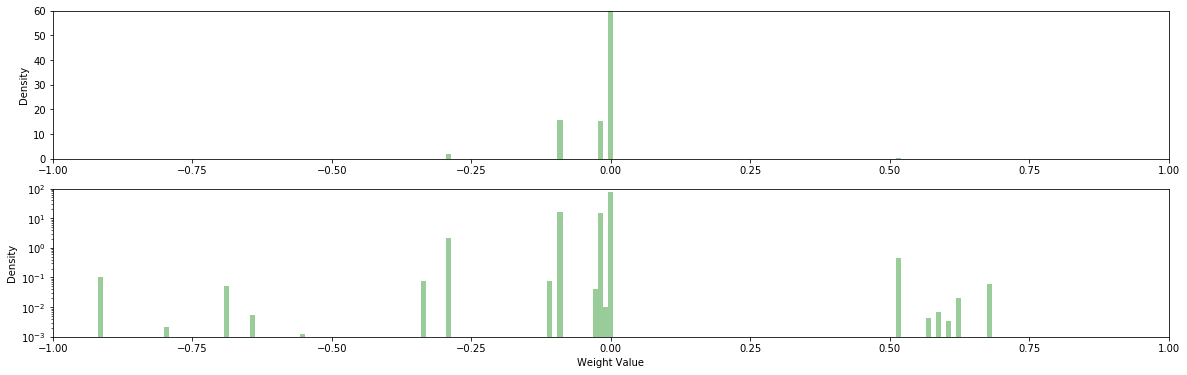

In [5]:
show_sws_weights(nm)


Tau: 2e-05, Epoch: 50. Test Accuracy: 97.49 Prune Accuracy: 96.05 Sparsity: 72.49
Tau: 4e-05, Epoch: 50. Test Accuracy: 97.02 Prune Accuracy: 96.26 Sparsity: 97.51
Tau: 6e-05, Epoch: 50. Test Accuracy: 96.63 Prune Accuracy: 96.06 Sparsity: 97.86
Tau: 8e-05, Epoch: 50. Test Accuracy: 96.21 Prune Accuracy: 95.72 Sparsity: 98.07
Tau: 0.0001, Epoch: 50. Test Accuracy: 95.57 Prune Accuracy: 95.18 Sparsity: 98.04

In [7]:
taus = [1e-5, 2e-5, 4e-5, 6e-5, 8e-5, 10e-5]
test_accs = [98.44, 97.49, 97.02, 96.63, 96.21, 95.57]
prune_accs = [98.42, 96.05, 96.26, 96.06, 95.72, 95.18]
spars = [52.50, 72.49, 97.51, 97.86, 98.07, 98.04]

In [10]:
prune_model = sws_prune_copy(model, gmp)
prune_acc = test_accuracy(test_data_full, test_labels_full, prune_model)
sparsity = get_sparsity(prune_model)
print('Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}'.format(epoch+1, test_acc[0], prune_acc[0], sparsity))

Epoch: 50. Test Accuracy: 95.58 Prune Accuracy: 95.05 Sparsity: 98.01
